In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/romba
!pwd


Mounted at /content/drive
/content/drive/MyDrive/romba
/content/drive/MyDrive/romba


In [ ]:
!pip install git+https://github.com/davidbau/baukit.git
!pip install dataclasses-json

  Cloning https://github.com/davidbau/baukit.git to /tmp/pip-req-build-h70ay4dx
  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit.git /tmp/pip-req-build-h70ay4dx
  Resolved https://github.com/davidbau/baukit.git to commit 9d51abd51ebf29769aecc38c4cbef459b731a36e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━

Metropolitan France |  Victor Bay | {} is located in the continent of


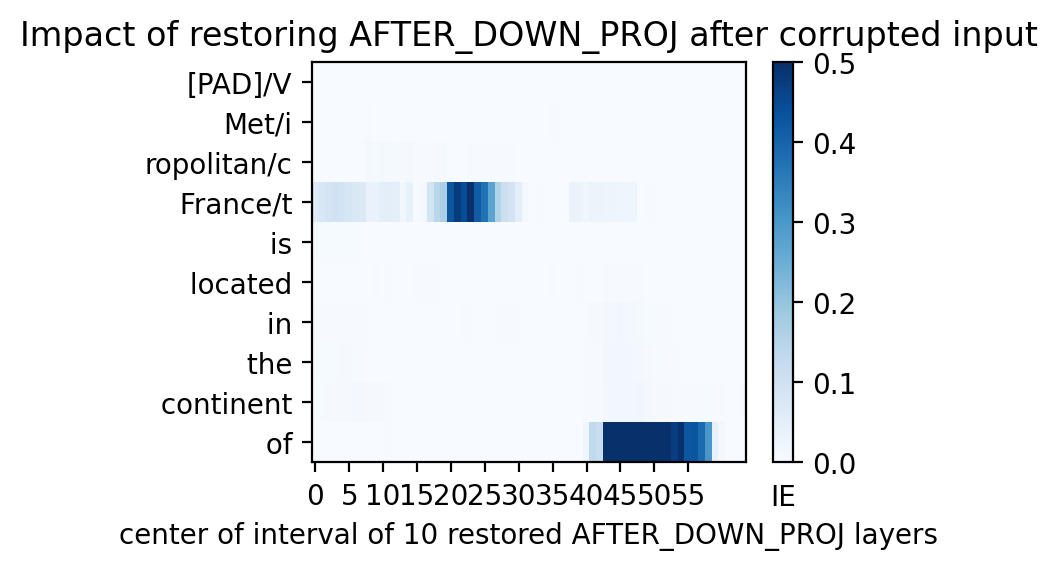

In [ ]:
import os
SAVE_DIR = f"../Figures/causal_tracing_examples"

idx = 0
FILE_NAME_PREFIX = f"{results[idx]['subject'].replace(' ', '_')}"
MODEL_PATH = "state-spaces/mamba-2.8b"

print(f"{results[idx]['subject']} |  {results[idx]['alt_subject']} | {sampled_prompts['data'][idx]['relation']}")
std_result = plot_trace_heatmap(
    results[idx],
    modelname=MODEL_PATH.split("/")[-1],
    relative_recovery=True,
    savepdf=os.path.join(SAVE_DIR, f"{FILE_NAME_PREFIX}_res.pdf"),
    scale_range=(0, 0.5)
)

In [163]:
import json


with open("filtered_counterfact_sample.json", 'r') as f:
  sampled_prompts = json.load(f)

In [229]:
import glob
import json
import torch

file_dir = "results/ssm_after_ssm/"
file_paths = glob.glob(file_dir + "*.json")

results = []
for file_path in file_paths:

  loaded_data = json.load(open(file_path))

  loaded_data["scores"] = torch.tensor(loaded_data["scores"])
  loaded_data["low_score"] = torch.tensor(loaded_data["low_score"])
  loaded_data["high_score"] = torch.tensor(loaded_data["high_score"])

  if loaded_data['category'] == '':
      continue
  results.append(loaded_data)

In [166]:
len(results)

77

In [225]:
def bin_token_indices(input_tokens, subject_range):
    start, end = subject_range
    T = len(input_tokens)
    bins = {
        "prefix": list(range(0, start)),
        "subject_[:-2]*": list(range(start, max(start, end-2))),
        "subject_2nd_last*": [end - 2] if end - start >= 2 else [],
        "subject_last*": [end - 1],
        "further tokens": list(range(end, T - 1)),
        "last token": [T - 1],
    }
    return bins

In [230]:
import torch
from collections import defaultdict
from collections import defaultdict

group_scores = defaultdict(list)  # key: (group, layer), value: list of IE values

# Initialize accumulators
group_names = ["prefix", "subject_[:-2]*", "subject_2nd_last*", "subject_last*", "further tokens", "last token"]
group_sums = {g: [] for g in group_names}


for result in results:
    scores = result["scores"]  # shape: [num_layers, num_tokens]
    bins = bin_token_indices(result["input_tokens"], result["subject_range"])
    scores = result['scores'] - result['low_score']

    for group, token_idxs in bins.items():
        for token_idx in token_idxs:
            for layer in range(scores.shape[1]):
                ie = scores[token_idx, layer].item()
                group_scores[(group, layer, result['category'])].append(ie)


avg_group_scores = [(group, layer, label, torch.tensor(scores).mean().item()) for (group, layer, label), scores in group_scores.items()]

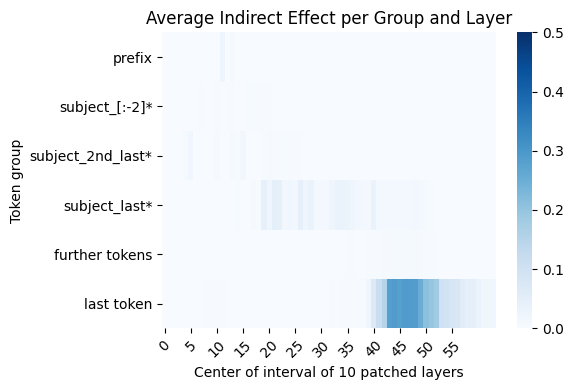

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


group_to_row = {g: i for i, g in enumerate(group_names)}

# Determine shape
max_layer = max(layer for _, layer, _, _ in avg_group_scores)
num_layers = max_layer + 1
num_groups = len(group_names)

# Create and populate heatmap
heatmap = np.full((num_groups, num_layers), np.nan)
for group, layer, label, avg_score in avg_group_scores:
    row = group_to_row[group]
    heatmap[row, layer] = avg_score

plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    heatmap,
    cmap="Blues",
    xticklabels=False,  # we'll manually set them
    yticklabels=False,  # same for y-axis
    vmin=0.0,
    vmax=0.5
)

# X-axis: one tick every 5 intervals (each interval = 10 layers)
x_range = heatmap.shape[1]
xticks = [0.5 + i for i in range(0, x_range-5, 5)]
xtick_labels = [5*(i//5) for i in range(0, x_range-5, 5)]  # center of 10-layer intervals

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

# Y-axis: center the tick at each row
yticks = [0.5 + i for i in range(len(group_names))]
ytick_labels = group_names

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

ax.set_xlabel("Center of interval of 10 patched layers")
ax.set_ylabel("Token group")
ax.set_title("Average Indirect Effect per Group and Layer")
plt.tight_layout()
plt.show()

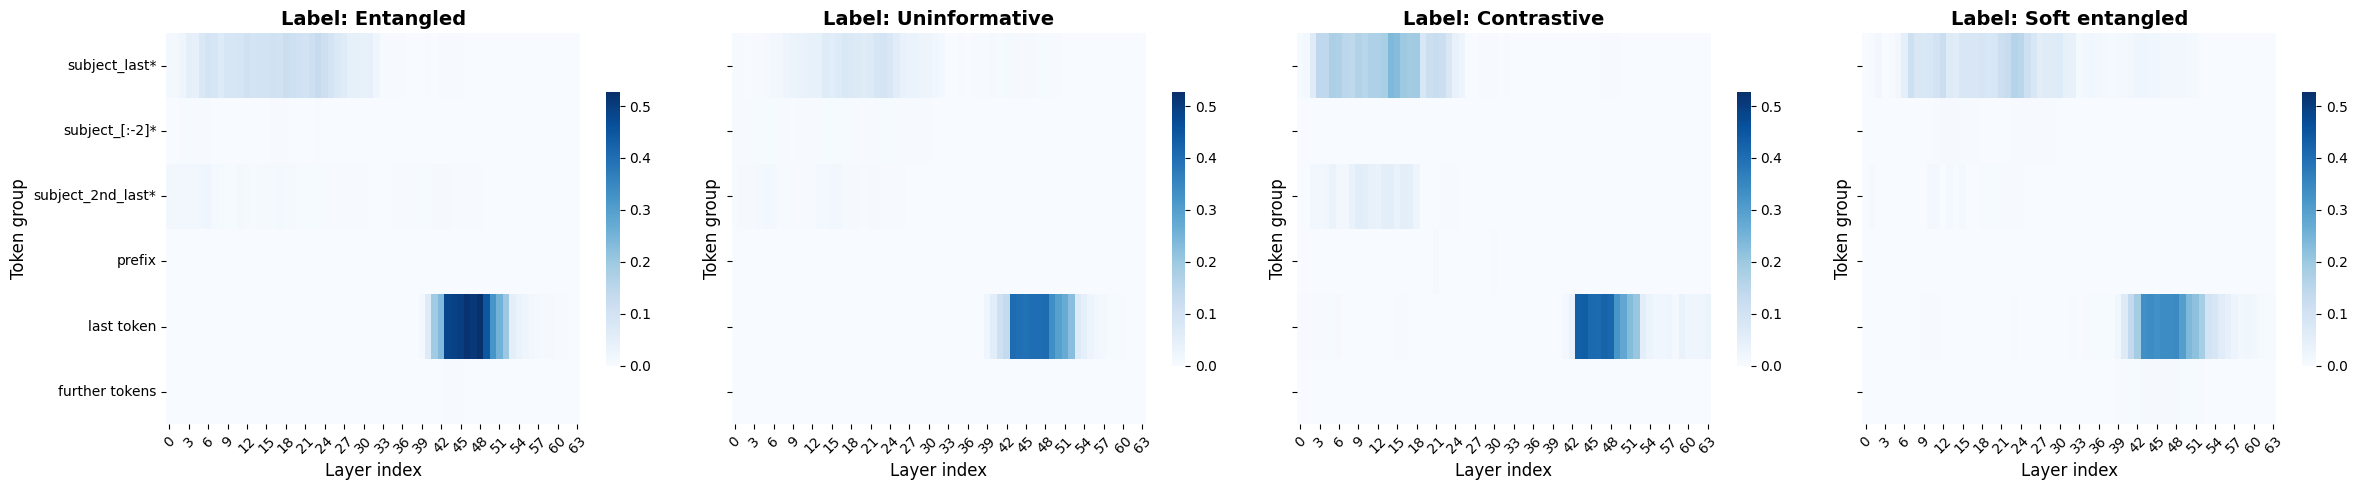

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Convert to DataFrame
df = pd.DataFrame(avg_group_scores, columns=["group", "layer", "label", "score"])

# Get all unique labels
unique_labels = df["label"].unique()

# Set up subplots
n_labels = len(unique_labels)
fig, axes = plt.subplots(nrows=1, ncols=n_labels, figsize=(6 * n_labels, 5), sharey=True)

# Ensure axes is iterable
if n_labels == 1:
    axes = [axes]

# Sort groups for consistent Y-axis
group_order = sorted(df["group"].unique(), reverse=True)

for ax, label in zip(axes, unique_labels):
    label_df = df[df["label"] == label]
    pivoted = label_df.pivot(index="group", columns="layer", values="score").reindex(group_order)

    sns.heatmap(
        pivoted,
        ax=ax,
        cmap="Blues",
        vmin=0,
        vmax=df["score"].max(),
        cbar=True,
        cbar_kws={"shrink": 0.7},
    )

    ax.set_title(f"Label: {label}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Layer index", fontsize=12)
    ax.set_ylabel("Token group", fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout(w_pad=2.5)
plt.show()


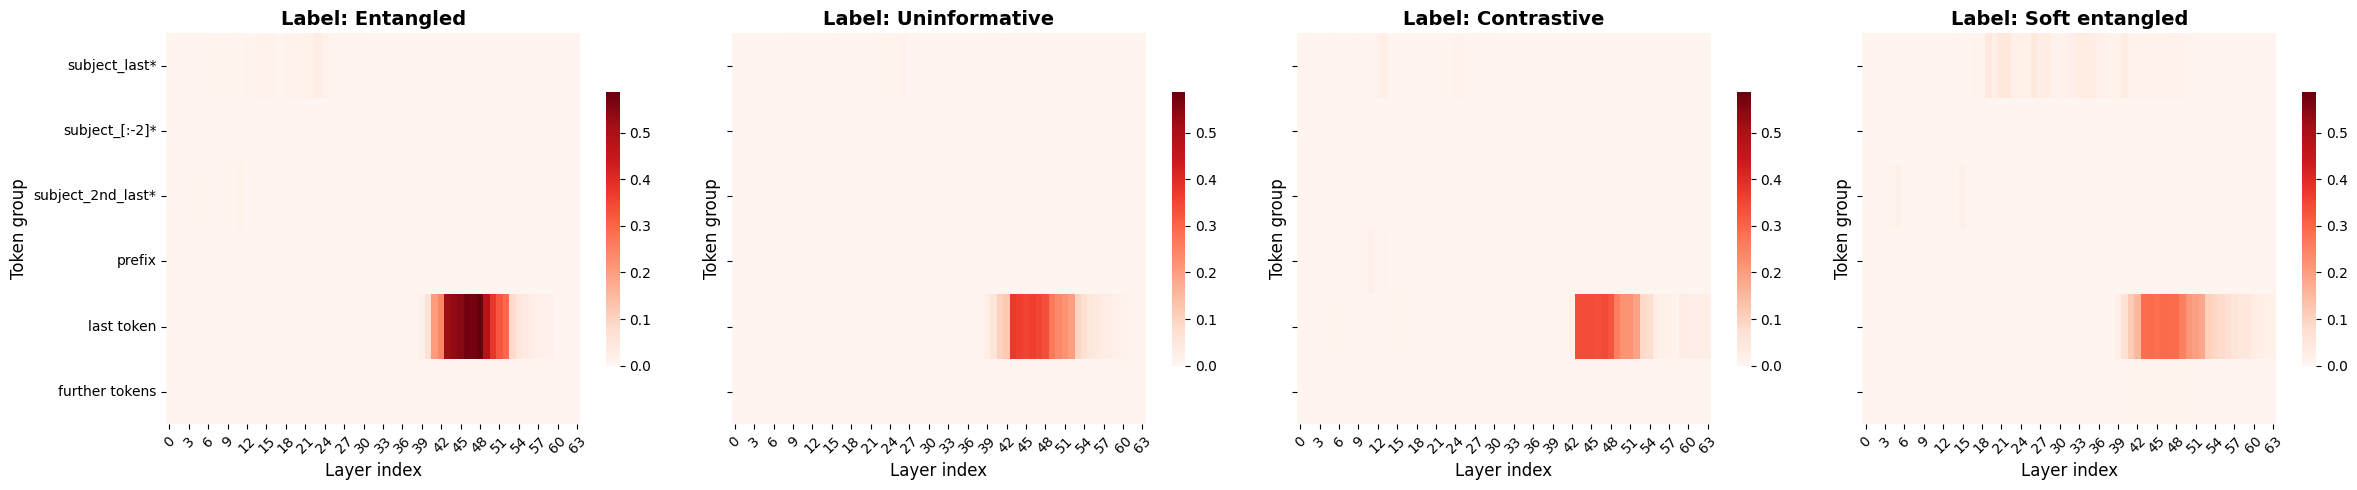

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Convert to DataFrame
df = pd.DataFrame(avg_group_scores, columns=["group", "layer", "label", "score"])

# Get all unique labels
unique_labels = df["label"].unique()

# Set up subplots
n_labels = len(unique_labels)
fig, axes = plt.subplots(nrows=1, ncols=n_labels, figsize=(6 * n_labels, 5), sharey=True)

# Ensure axes is iterable
if n_labels == 1:
    axes = [axes]

# Sort groups for consistent Y-axis
group_order = sorted(df["group"].unique(), reverse=True)

for ax, label in zip(axes, unique_labels):
    label_df = df[df["label"] == label]
    pivoted = label_df.pivot(index="group", columns="layer", values="score").reindex(group_order)

    sns.heatmap(
        pivoted,
        ax=ax,
        cmap="Reds",
        vmin=0,
        vmax=df["score"].max(),
        cbar=True,
        cbar_kws={"shrink": 0.7},
    )

    ax.set_title(f"Label: {label}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Layer index", fontsize=12)
    ax.set_ylabel("Token group", fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout(w_pad=2.5)
plt.show()


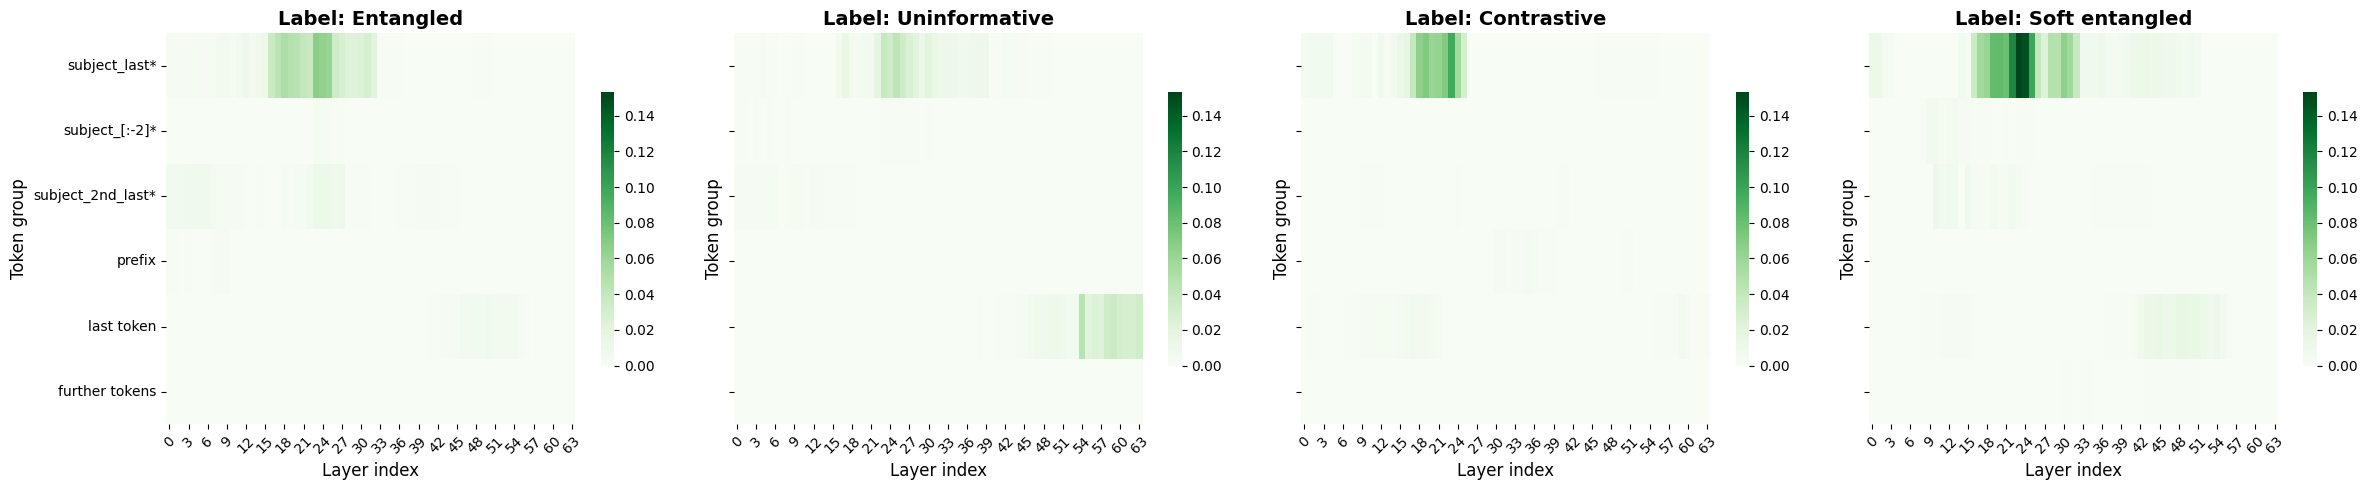

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Convert to DataFrame
df = pd.DataFrame(avg_group_scores, columns=["group", "layer", "label", "score"])

# Get all unique labels
unique_labels = df["label"].unique()

# Set up subplots
n_labels = len(unique_labels)
fig, axes = plt.subplots(nrows=1, ncols=n_labels, figsize=(6 * n_labels, 5), sharey=True)

# Ensure axes is iterable
if n_labels == 1:
    axes = [axes]

# Sort groups for consistent Y-axis
group_order = sorted(df["group"].unique(), reverse=True)

for ax, label in zip(axes, unique_labels):
    label_df = df[df["label"] == label]
    pivoted = label_df.pivot(index="group", columns="layer", values="score").reindex(group_order)

    sns.heatmap(
        pivoted,
        ax=ax,
        cmap="Greens",
        vmin=0,
        vmax=df["score"].max(),
        cbar=True,
        cbar_kws={"shrink": 0.7},
    )

    ax.set_title(f"Label: {label}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Layer index", fontsize=12)
    ax.set_ylabel("Token group", fontsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout(w_pad=2.5)
plt.show()


In [206]:
def get_plot(file_dir, color):
  file_paths = glob.glob(file_dir + "*.json")

  results = []

  unlabeled_data = 0
  for file_path in file_paths:

    loaded_data = json.load(open(file_path))

    loaded_data["scores"] = torch.tensor(loaded_data["scores"])
    loaded_data["low_score"] = torch.tensor(loaded_data["low_score"])
    loaded_data["high_score"] = torch.tensor(loaded_data["high_score"])


    if loaded_data['category'] == '':
      continue
    results.append(loaded_data)
  group_scores = defaultdict(list)  # key: (group, layer), value: list of IE values

  # Initialize accumulators
  group_names = ["prefix", "subject_[:-2]*", "subject_2nd_last*", "subject_last*", "further tokens", "last token"]
  group_sums = {g: [] for g in group_names}


  for result in results:
      scores = result["scores"]  # shape: [num_layers, num_tokens]
      bins = bin_token_indices(result["input_tokens"], result["subject_range"])
      scores = result['scores'] - result['low_score']

      for group, token_idxs in bins.items():
          for token_idx in token_idxs:
              for layer in range(scores.shape[1]):
                  ie = scores[token_idx, layer].item()
                  group_scores[(group, layer, result['category'])].append(ie)


  avg_group_scores = [(group, layer, label, torch.tensor(scores).mean().item()) for (group, layer, label), scores in group_scores.items()]
  import matplotlib.pyplot as plt
  import seaborn as sns
  import numpy as np


  group_to_row = {g: i for i, g in enumerate(group_names)}

  # Determine shape
  max_layer = max(layer for _, layer, _, _ in avg_group_scores)
  num_layers = max_layer + 1
  num_groups = len(group_names)

  # Create and populate heatmap
  heatmap = np.full((num_groups, num_layers), np.nan)
  for group, layer, label, avg_score in avg_group_scores:
      row = group_to_row[group]
      heatmap[row, layer] = avg_score

  plt.figure(figsize=(6, 4))
  ax = sns.heatmap(
      heatmap,
      cmap=color,
      xticklabels=False,  # we'll manually set them
      yticklabels=False,  # same for y-axis
      vmin=0.0,
      vmax=0.5
  )

  # X-axis: one tick every 5 intervals (each interval = 10 layers)
  x_range = heatmap.shape[1]
  xticks = [0.5 + i for i in range(0, x_range-5, 5)]
  xtick_labels = [5*(i//5) for i in range(0, x_range-5, 5)]  # center of 10-layer intervals

  ax.set_xticks(xticks)
  ax.set_xticklabels(xtick_labels, rotation=45)

  # Y-axis: center the tick at each row
  yticks = [0.5 + i for i in range(len(group_names))]
  ytick_labels = group_names

  ax.set_yticks(yticks)
  ax.set_yticklabels(ytick_labels)

  ax.set_xlabel("Center of interval of 10 patched layers")
  ax.set_ylabel("Token group")
  ax.set_title("Average Indirect Effect per Group and Layer")
  plt.tight_layout()
  plt.show()


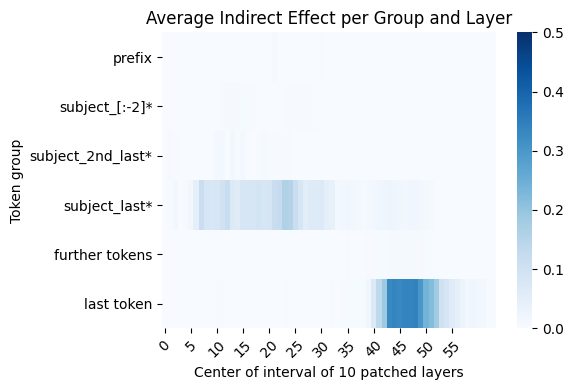

In [207]:
get_plot( "results/after_down_proj/", "Blues")

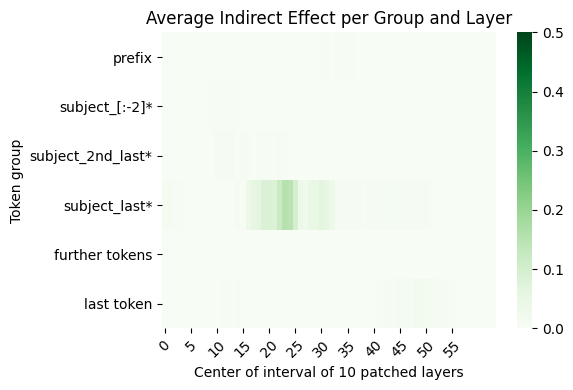

In [208]:
get_plot( "results/mlp_after_silu/", "Greens")

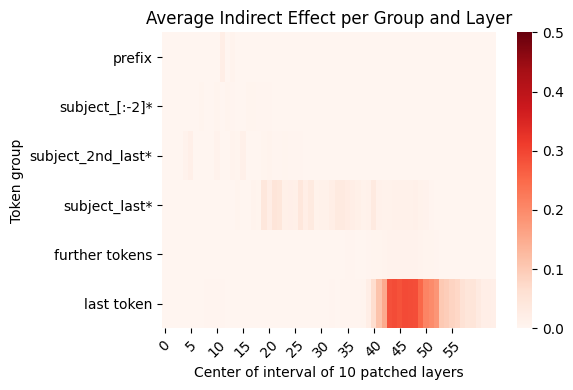

In [209]:
get_plot( "results/ssm_after_ssm/", "Reds")